In [61]:
import numpy as np
import pandas as pd
import math
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from tqdm import tqdm_notebook

from itertools import product
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_excel('CBA.AX5y.xls')

In [40]:
df.columns = df.columns.str.lower()

In [41]:
df = df.drop(labels = ['open', 'high', 'low', 'adj close'], axis=1)

In [42]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [43]:
df.head()

,close,volume
date,,
2017-09-21,76.070000,4104401
2017-09-22,76.620003,2170239
2017-09-25,75.809998,2003512
2017-09-26,75.099998,2552948
2017-09-27,74.849998,2688235


In [48]:
df = df.drop(labels = ['volume'], axis=1)

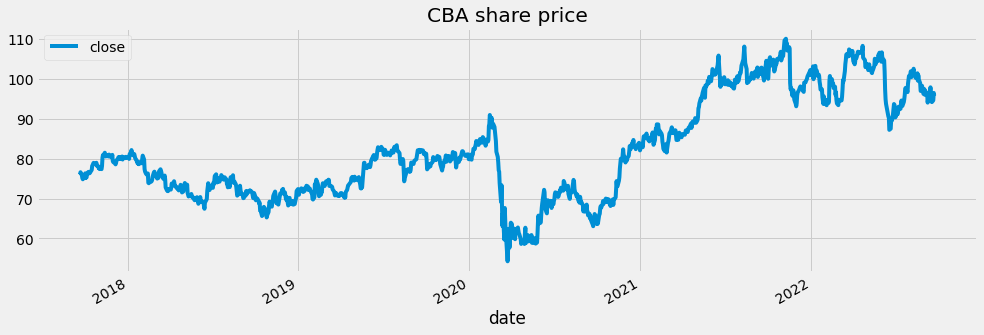

In [49]:
df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='CBA share price')
plt.show()

### Check for Stationarity

In [36]:
#def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("ADF: ",dftest[0])
    print("P-Value: ", dftest[1])
    print("Number of Lags: ",dftest[2])
    print("Number of observation used for ADF Regression and critical values calculation: ",dftest[3])
    print("Critical values: ")
    for key, val in dftest[4].items():
        print("\t",key,": ", val)

IndentationError: unexpected indent (479899968.py, line 2)

In [37]:
#ad_test(train['close'])

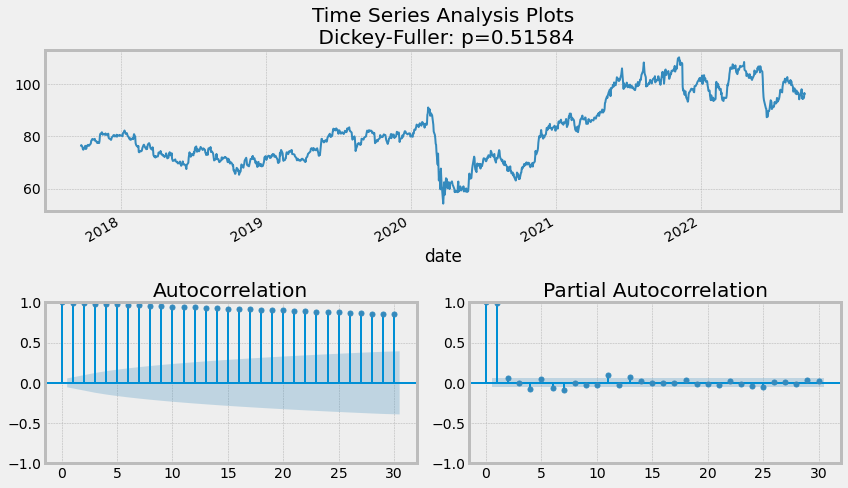

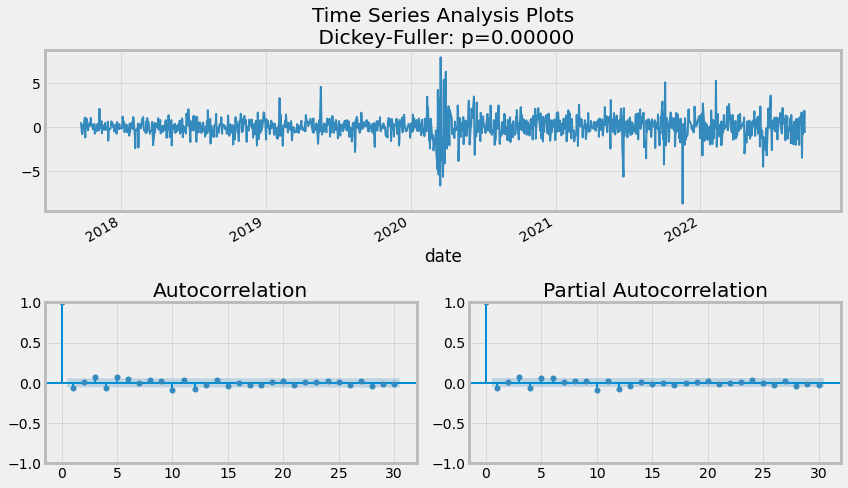

In [50]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.close, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = df.close - df.close.shift(1)

tsplot(data_diff[1:], lags=30)

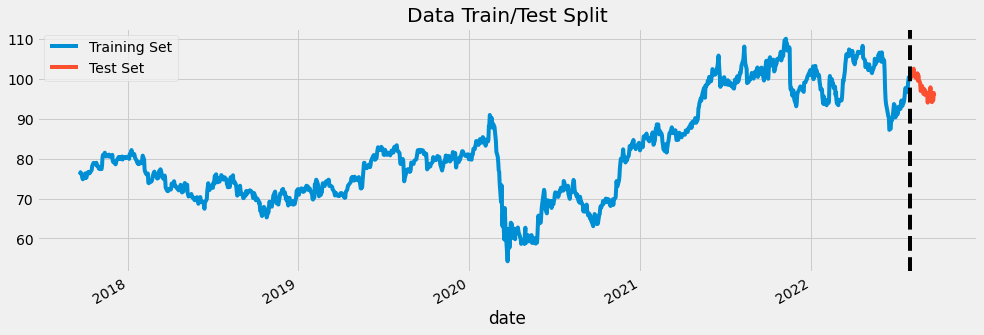

In [51]:
train = df.loc[df.index < '2022-08-01']
test = df.loc[df.index >= '2022-08-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2022-08-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [52]:
print(len(train))
print(len(test))

1229
38


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69288D+00    |proj g|=  2.36891D-01


 This problem is unconstrained.



At iterate    5    f=  1.61781D+00    |proj g|=  3.98577D-02

At iterate   10    f=  1.58489D+00    |proj g|=  2.29035D-02

At iterate   15    f=  1.58096D+00    |proj g|=  4.01557D-03

At iterate   20    f=  1.58069D+00    |proj g|=  7.36777D-03

At iterate   25    f=  1.57989D+00    |proj g|=  8.65814D-03

At iterate   30    f=  1.57986D+00    |proj g|=  6.07266D-04

At iterate   35    f=  1.57983D+00    |proj g|=  2.43314D-03

At iterate   40    f=  1.57927D+00    |proj g|=  1.34706D-02

At iterate   45    f=  1.57890D+00    |proj g|=  8.16006D-03

At iterate   50    f=  1.57882D+00    |proj g|=  2.01459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<AxesSubplot:xlabel='date'>

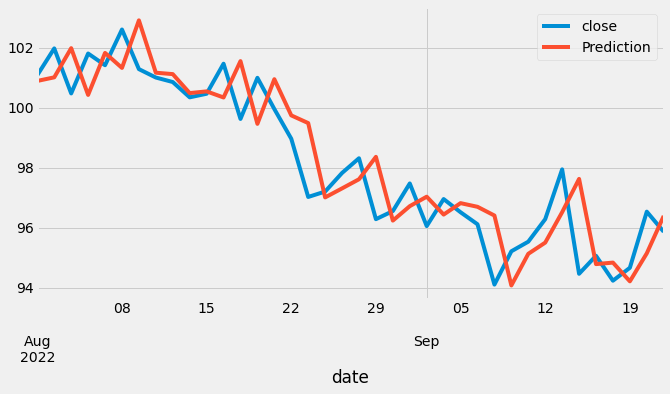

In [74]:
model = sm.tsa.statespace.SARIMAX(df['close'], order=(4,1,4), seasonal_order=(2,1,1,5))
res = model.fit()
start = len(train)
end = len(train) + len(test) - 1 #index number starts from zero
prediction = res.predict(start, end).rename('Prediction')
ax = test['close'].plot(legend=True, figsize = (10,5))
prediction.plot(legend=True)

In [75]:
mse = np.square(np.subtract(df['close'],prediction)).mean()   
   
rsme = math.sqrt(mse)  
print("Root Mean Square Error:\n")  
print(rsme)  

Root Mean Square Error:

1.1962196987797618


In [64]:
score = np.sqrt(mean_squared_error(test['close'], prediction))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1.20


In [65]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,30)]

In [66]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [67]:
future_datest_df.tail()

,close
2022-10-16,NaN
2022-10-17,NaN
2022-10-18,NaN
2022-10-19,NaN
2022-10-20,NaN


In [68]:
future_df=pd.concat([df,future_datest_df])

In [72]:
future_df.index

DatetimeIndex(['2017-09-21', '2017-09-22', '2017-09-25', '2017-09-26',
               '2017-09-27', '2017-09-28', '2017-09-29', '2017-10-02',
               '2017-10-03', '2017-10-04',
               ...
               '2022-10-11', '2022-10-12', '2022-10-13', '2022-10-14',
               '2022-10-15', '2022-10-16', '2022-10-17', '2022-10-18',
               '2022-10-19', '2022-10-20'],
              dtype='datetime64[ns]', length=1296, freq=None)

In [76]:
future_df.head()

,close,forecast
2017-09-21,76.070000,NaN
2017-09-22,76.620003,NaN
2017-09-25,75.809998,NaN
2017-09-26,75.099998,NaN
2017-09-27,74.849998,NaN


<AxesSubplot:>

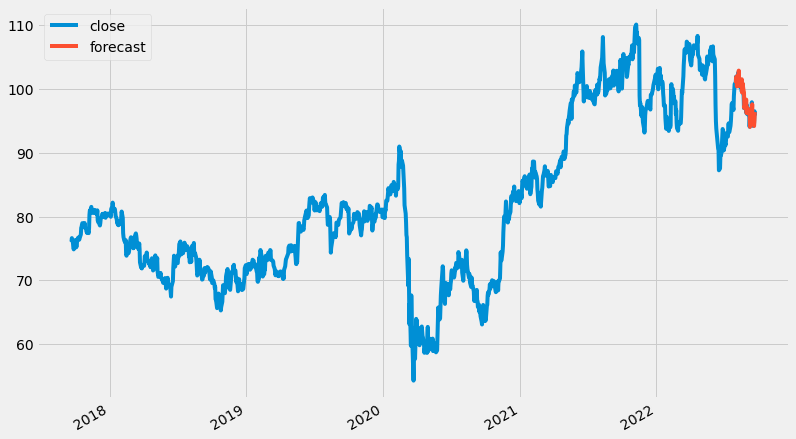

In [73]:
future_df['forecast'] = res.predict(start = 104, end = 120, dynamic= True) 
future_df[['close', 'forecast']].plot(figsize=(12, 8)) 

In [77]:
future_df['forecast']

2017-09-21   NaN
2017-09-22   NaN
2017-09-25   NaN
2017-09-26   NaN
2017-09-27   NaN
              ..
2022-10-16   NaN
2022-10-17   NaN
2022-10-18   NaN
2022-10-19   NaN
2022-10-20   NaN
Name: forecast, Length: 1296, dtype: float64